In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os 
from scipy.spatial import Delaunay
import tarfile
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from discretize import TensorMesh, SimplexMesh
from pymatsolver import PardisoSolver
import matplotlib.colors as mcolors
from SimPEG.utils import mkvc
from SimPEG import (
    maps, data, data_misfit, inverse_problem, regularization, optimization,
    directives, inversion, utils
    )
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG.electromagnetics.utils.em1d_utils import (
    get_vertical_discretization, set_mesh_1d, Stitched1DModel, plot_layer
)

In [2]:
# Load field data

dir_path = 'E:\\HYES\\DY78\\反演\\ROV\\Dec\\'
data_filename = dir_path + "78II-SWIR-ROV01S01-04Dec -sgolay2.txt"

In [3]:
df = pd.read_csv(data_filename,skiprows=0,delim_whitespace=True,index_col=False)

Text(0.5, 1.0, 'Observed data')

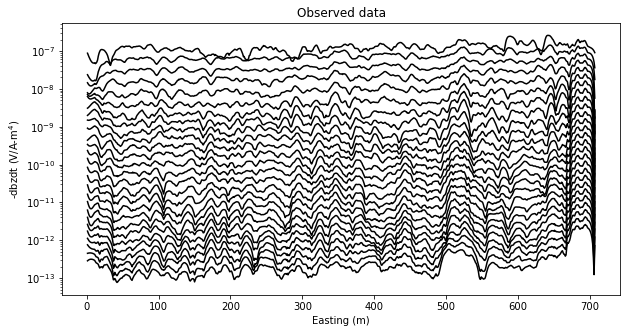

In [5]:
lineno=0
times = np.loadtxt(dir_path + "ROV01S03times.txt")
xyz = df[['EAST','NORTH','LEVEL']].values
line=df['LINENO'].values.astype(float)
n_sounding = np.shape(xyz)[0]
n_time = len(times)
group_line = df.groupby('LINENO')
uniq_line = list(group_line.groups.keys())
data_header = np.array(list(key for key in df.columns[6::]))
data_tmp = group_line.get_group(uniq_line[lineno])[data_header].values
flag = np.logical_and(times<20e-3,times>1e-6)
times = times[flag]
data_tmp = data_tmp[:,flag]


fig, ax = plt.subplots(1,1,figsize=(10, 5))
x = group_line.get_group(uniq_line[lineno])['STATION'].values
ax.semilogy(x, data_tmp, 'k')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("-dbzdt (V/A-m$^4$)")
ax.set_title("Observed data")

In [6]:
data_all = df[data_header].values
data_all = data_all[:,flag]

In [7]:
data_all.size

86994

In [8]:
times

array([0.0001424, 0.0001712, 0.0002064, 0.000248 , 0.0002976, 0.0003584,
       0.0004304, 0.0005168, 0.0006224, 0.0007472, 0.0008976, 0.0010784,
       0.0012976, 0.0015584, 0.0018736, 0.0022512, 0.0027056, 0.0032512,
       0.0039072, 0.004696 , 0.0056432, 0.0067824, 0.008152 , 0.0097968,
       0.0117728, 0.0141488, 0.0170032])

In [9]:
data_all.shape

(3222, 27)

In [10]:
xyz.shape

(3222, 3)

Text(0.5, 1.0, 'Observed data')

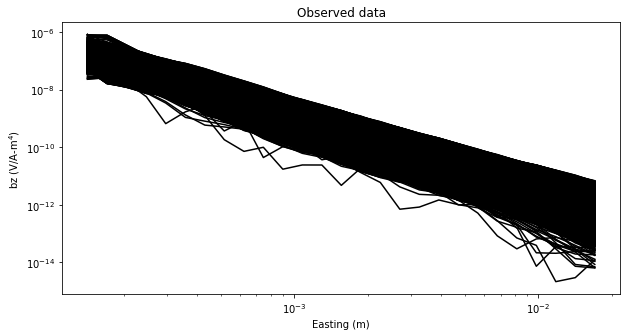

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.loglog(times, data_all.T, 'k')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("bz (V/A-m$^4$)")
ax.set_title("Observed data")

In [12]:

xya = df[['EAST','NORTH','SRCLOC']].values
xya.shape

(3222, 3)

In [13]:
######################################################
# Create Survey
# -------------

source_locations = xyz.copy()  # xyz locations for the centre of the loop
current_amplitude = 1.
source_radius = np.sqrt(1./3.1415)

# receiver_locations = np.c_[source_locations[:, 0], source_locations[:, 1:]]
receiver_locations = source_locations.copy()+[1,0,0]
receiver_orientation = "z"

waveform = tdem.sources.StepOffWaveform()


eps = 50e-6
ramp_on = np.r_[-0.025, -0.025+eps]
ramp_off = np.r_[-eps, 0.]
Trapezoid_waveform = tdem.sources.TrapezoidWaveform(
    ramp_on=ramp_on, ramp_off=ramp_off
)

source_list = []

for ii in range(0, n_sounding):

    source_location = mkvc(source_locations[ii, :])
    receiver_location = mkvc(receiver_locations[ii, :])

    receiver_list = [
        tdem.receivers.PointMagneticFluxTimeDerivative( #PointMagneticFluxTimeDerivative #PointMagneticFluxDensity
            receiver_location, times, orientation=receiver_orientation
        )
    ]

    # Sources

    source_list.append(
        tdem.sources.MagDipole( #MagDipole
            receiver_list=receiver_list, location=source_location, waveform=Trapezoid_waveform,i_sounding=ii
        )
    )

# Survey
survey = tdem.Survey(source_list)

>> Depth from the surface to the base of the bottom layer is 90.0m


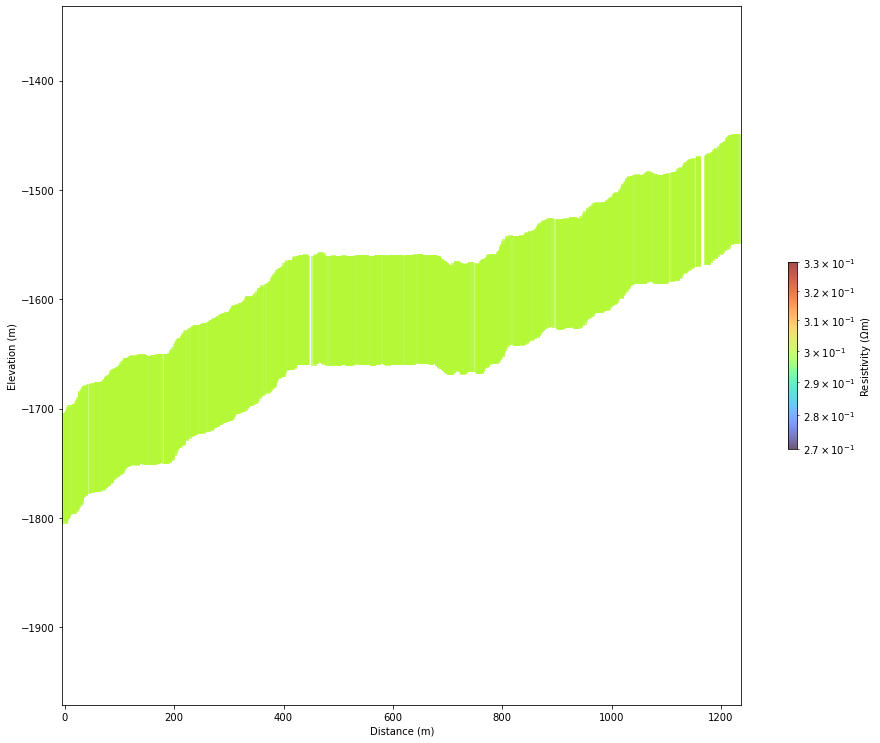

In [16]:
###############################################
# Defining a Global Mesh and Model
# --------------------------------

# topography
topography = xyz.copy()

# vertical cell widths
n_layer = 25
thicknesses = get_vertical_discretization(n_layer-1, 0.8, 1.1166)
hz = np.r_[thicknesses, thicknesses[-1]]  # We need to include a thickness for bottom layer

# A function for generating a wedge layer 
def get_y(x):
    y = 30/10 * x + 10.
    return y

# Conductivity values for each unit
background_conductivity = 1./0.3
layer_conductivity = 1./0.01

# Define a 1D vertical mesh
mesh_1d = set_mesh_1d(hz)
# Generate a stitched 1D model
conductivity = np.zeros((n_sounding, n_layer), dtype=float)

for i_sounding in range(n_sounding):
    y = get_y(xya[i_sounding, 2])
    layer_ind = np.logical_and(mesh_1d.vectorCCx>50., mesh_1d.vectorCCx<y)
    conductivity_1d = np.ones(n_layer, dtype=float) * background_conductivity
    conductivity_1d[layer_ind] = layer_conductivity
    conductivity[i_sounding,:]=conductivity_1d

# Note: oder of the conductivity model 
stitched_conductivity_model = conductivity.flatten()

# Generate a Stitched1DModel object for plotting
model_plot = Stitched1DModel(
    hz=hz,
    line=line,
    topography=topography,
    #physical_property=1./ModelRef.T.reshape(-1)
    physical_property=1./stitched_conductivity_model
)

_, ax, cb = model_plot.plot_section(cmap='turbo', x_axis='distance',aspect=2, dx=5, i_line=1)
cb.set_label("Resistivity ($\Omega$m)")

In [17]:
hz

array([ 0.8       ,  0.89328   ,  0.99743645,  1.11373754,  1.24359933,
        1.38860302,  1.55051413,  1.73130408,  1.93317413,  2.15858224,
        2.41027292,  2.69131075,  3.00511758,  3.35551429,  3.74676726,
        4.18364032,  4.67145278,  5.21614417,  5.82434658,  6.5034654 ,
        7.26176946,  8.10849178,  9.05394192, 10.10963155, 10.10963155])

In [18]:
#######################################################################
# Define the Mapping, Forward Simulation and Predict Data
# -------------------------------------------------------

# Model and mapping. Here the model is defined by the log-conductivity.
stitched_model = np.log(stitched_conductivity_model)
mapping = maps.ExpMap(nP=len(stitched_model))

# Define the simulation
simulation = tdem.Simulation1DLayeredStitched(
    survey=survey, thicknesses=thicknesses, sigmaMap=mapping,
    topo=topography,
    parallel=True, n_cpu=60, solver=PardisoSolver
)

survey_norm = tdem.Survey([source_list[0]]) 
norm_model = np.log(np.ones(n_layer, dtype=float) * background_conductivity)
mapping_norm = maps.ExpMap(nP=len(norm_model))

simulation_norm = tdem.Simulation1DLayeredStitched(
    survey=survey_norm, thicknesses=thicknesses, sigmaMap=mapping_norm,
    topo=topography,
    parallel=False, n_cpu=60, solver=PardisoSolver
)

>> Use multiprocessing for parallelization
>> n_cpu: 60
>> Serial version is used


In [19]:
%%time
# Predict data
dpred_norm_single = simulation_norm.dpred(norm_model)

CPU times: total: 93.8 ms
Wall time: 170 ms


C:\Users\dell\anaconda3\lib\site-packages\geoana\kernels\tranverse_electric_reflections.py:37: RuntimeWarning: overflow encountered in tanh
  tanh = np.tanh(u[:-1]*thicknesses[:, None, None])


In [20]:
dpred_norm_single

array([-2.73205432e-07, -1.82313397e-07, -1.20021368e-07, -7.90878533e-08,
       -5.19665375e-08, -3.36874127e-08, -2.18820809e-08, -1.41613156e-08,
       -9.06751002e-09, -5.83272550e-09, -3.73645811e-09, -2.38764802e-09,
       -1.51719235e-09, -9.67020110e-10, -6.13919915e-10, -3.89849476e-10,
       -2.47127525e-10, -1.56539468e-10, -9.90102313e-11, -6.25221877e-11,
       -3.94235530e-11, -2.47965865e-11, -1.55501821e-11, -9.71979904e-12,
       -6.05056114e-12, -3.74413323e-12, -2.30277054e-12])

In [21]:
%%time
# Predict data
dpred = simulation.dpred(stitched_model)

CPU times: total: 3.42 s
Wall time: 8min 41s


Text(0.5, 1.0, 'Line nubmer 0')

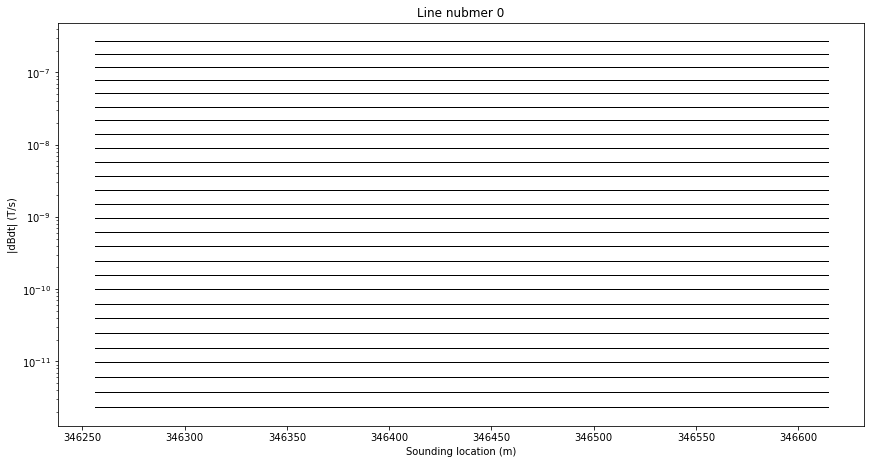

In [22]:
#######################################################################
# Plotting Results
# ----------------

d = np.reshape(dpred, (n_sounding, len(times)))

fig= plt.figure(figsize=(14, 7))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])
unique_line = np.unique(line)
i_line = 0
ind_line = line == unique_line[i_line]
for ii in range(0, len(times)):
    ax.semilogy(receiver_locations[ind_line, 0], np.abs(d[ind_line, ii]), 'k-', lw=1)
ax.set_xlabel("Sounding location (m)")
ax.set_ylabel("|dBdt| (T/s)")
ax.set_title("Line nubmer {:.0f}".format(i_line))

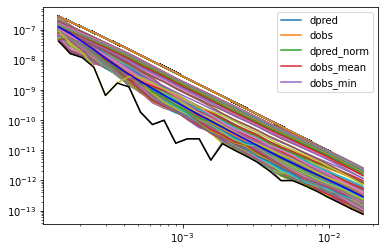

In [23]:
plt.loglog(times,-d.T);
plt.loglog(times,data_tmp.T);
plt.loglog(times,dpred_norm_single,'r');
plt.loglog(times,np.mean(data_tmp,0),'b');
plt.loglog(times,np.min(data_tmp,0),'k');
plt.legend(
    ["dpred","dobs", "dpred_norm", "dobs_mean", "dobs_min",],
    loc='upper right'
)

In [24]:
#dobs_norm = np.exp((np.log(data_all)/np.log(np.min(data_all,0)))*np.log(dpred_norm_single))*np.log(1/times)/np.log(np.min(1/times))
#dobs_norm = np.exp((np.log(data_all)/np.log(np.min(data_all,0)))*np.log(dpred_norm_single))
#dobs_norm = np.exp(10*(data_all-np.min(data_all,0))/(np.max(data_all,0)-np.min(data_all,0)))*dpred_norm_single
#dobs_norm = 314.15*data_all*dpred_norm_single/np.abs(dobs_sea[0:27])
dobs_norm = -data_all

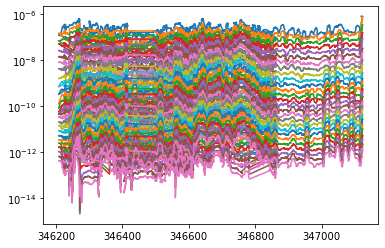

In [25]:
plt.semilogy(receiver_locations[:, 0],-dobs_norm);

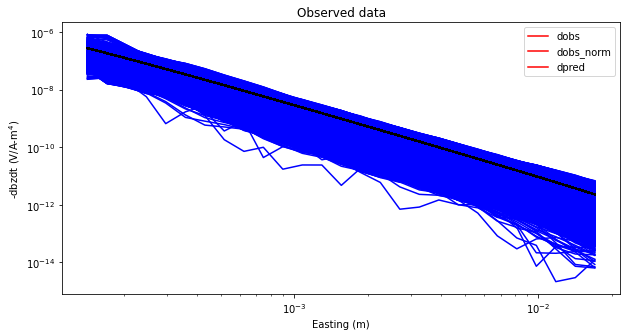

In [26]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.loglog(times, -data_tmp.T/(50*4*28.7),'r')
ax.loglog(times, -dobs_norm.T, 'b')
ax.loglog(times, -d.T, 'k')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("-dbzdt (V/A-m$^4$)")
ax.set_title("Observed data")

plt.legend(
    ["dobs","dobs_norm", "dpred",],
    loc='upper right'
)

>> Depth from the surface to the base of the bottom layer is 90.0m


C:\Users\dell\anaconda3\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TensorMesh.vectorNx has been deprecated, please use TensorMesh.nodes_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


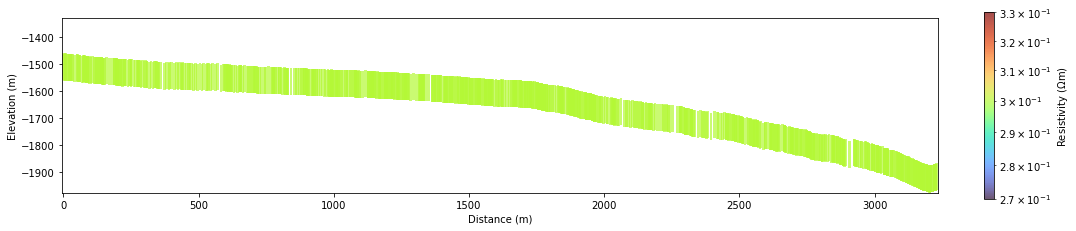

In [27]:
n_layer = 25
#thicknesses = get_vertical_discretization(n_layer-1, 0.8, 1.1166)
thicknesses = get_vertical_discretization(n_layer-1, 0.8, 1.1166)
n_param = n_layer*n_sounding  # Number of model parameters

# Define the conductivities for all layers for all soundings into a 1D array.
conductivity = np.ones(n_param) * 1./0.3

# Define the mapping between the model and the conductivitys
mapping = maps.ExpMap(nP=n_param)

# Define the starting model
starting_model = np.log(conductivity)

_, ax, cb = model_plot.plot_section(cmap='turbo', x_axis='distance',aspect=1, dx=5, i_line=2)
ax.scatter(np.sqrt(np.square(xya[:,0])+np.square(xya[:,1]))-3, xyz[:,2]+10, 100, c='b')
cb.set_label("Resistivity ($\Omega$m)")

In [30]:
# Define uncertainties
dobs = dobs_norm.flatten() # data_tmp d_norm data_all dobs_norm
uncertainties = 0.05*np.abs(dobs)*np.ones(np.shape(dobs))
# Define the data object
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
dmis.W = 1./uncertainties

#reg mesh
hz = np.r_[thicknesses, thicknesses[-1]]  # We need to include a thickness for bottom layer
tri = Delaunay(source_locations[:,:2])
mesh_radial = SimplexMesh(tri.points, tri.simplices)
mesh_vertical = set_mesh_1d(hz)
#
#mesh_reg = [mesh_radial, mesh_vertical]
#n_param = int(mesh_radial.n_nodes * mesh_vertical.nC)
#reg_map = maps.IdentityMap(nP=n_param)    # Mapping between the model and regularization
#reg = regularization.LaterallyConstrained(
#    mesh_reg, mapping=reg_map,
#    alpha_s = 1e-2,
#    alpha_r = 1.,
#    alpha_z = 1.,
#)
#mtrue=np.ones((25,3220)).reshape(-1),
mesh_reg = TensorMesh([hz, np.ones(n_sounding)*2])
regmap = maps.IdentityMap(mesh_reg)
reg = regularization.Sparse(
    mesh_reg, mapping=regmap,
    alpha_s =  1e-3,#1e-10
    alpha_x =  1e-1,
    alpha_y =  1e-1,
    alpha_z =  1e-1,
    #mref = np.ones_like(mtrue)
#     mref = ModelRef.T.reshape(-1)
)
#reg.cell_weight=mref_weight.reshape(-1)
# reg.mrefInSmooth = False
reg.norms = np.c_[2,2,2,2]


opt = optimization.InexactGaussNewton(maxIter = 20, maxIterCG=20)
opt.remember('xc')
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

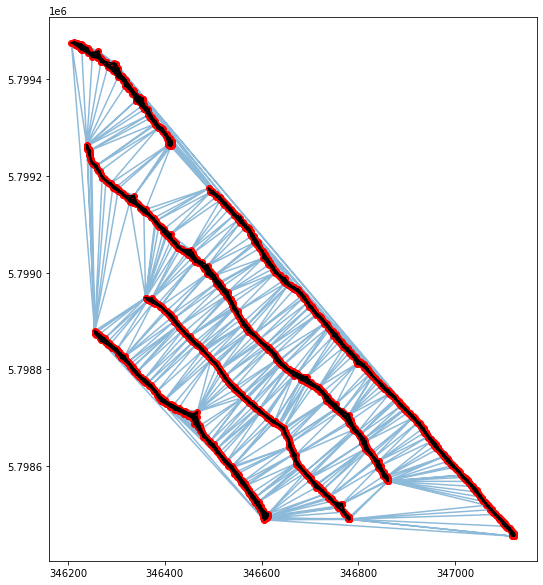

In [31]:
xyz = source_locations.copy()
def get_active_edge_indices_with_distance(mesh_radial, mesh_vertical, maximum_distance=10):
    nz = mesh_vertical.n_cells
    edge_lengths = mesh_radial.edge_lengths
    inds = edge_lengths < maximum_distance
    indActiveEdges = np.tile(inds.reshape([-1,1]), nz).flatten()
    return inds, indActiveEdges

fig = plt.figure(figsize=(10, 10))
plt.triplot(xyz[:,0], xyz[:,1], tri.simplices[:,:], alpha=0.5)
plt.plot(xyz[:,0], xyz[:,1], 'ro')

inds, indActiveEdges = get_active_edge_indices_with_distance(
    mesh_radial, mesh_vertical, maximum_distance=20
)
fr = mesh_radial.nodes[mesh_radial._edges[inds,:][:,0],:]
to = mesh_radial.nodes[mesh_radial._edges[inds,:][:,1],:]

for ii in range(fr.shape[0]):
    plt.plot([fr[ii,0], to[ii,0]], [fr[ii,1], to[ii,1]], 'k')
plt.gca().set_aspect(1)

In [32]:
#######################################################################
# Define Inversion Directives
# ---------------------------


# Defining a starting value for the trade-off parameter (beta) between the data
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)

# Defining how to cool the trade-off parameter, beta, through out the inversion

beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
target =directives.TargetMisfit()

update_IRLS = directives.Update_IRLS(
    max_irls_iterations=30, minGNiter=2,
    coolEpsFact=1.5, update_beta=True
)
update_Jacobi = directives.UpdatePreconditioner()

# The directives are defined as a list.
directives_list = [
    starting_beta,
    beta_schedule,
    target,
]


inv = inversion.BaseInversion(inv_prob, directives_list)

In [33]:
%%time
recovered_model = inv.run(starting_model)

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


C:\Users\dell\anaconda3\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TensorMesh._cellGradxStencil has been deprecated, please use TensorMesh.stencil_cell_gradient_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
C:\Users\dell\anaconda3\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TensorMesh._cellGradyStencil has been deprecated, please use TensorMesh.stencil_cell_gradient_y. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.85e+08  4.43e+09  0.00e+00  4.43e+09    1.43e+09      0              
   1  3.43e+08  2.06e+09  6.64e-01  2.29e+09    2.28e+08      0              
   2  1.71e+08  1.43e+09  1.88e+00  1.75e+09    5.36e+07      0   Skip BFGS  
   3  8.57e+07  1.12e+09  3.36e+00  1.41e+09    3.96e+07      0   Skip BFGS  
   4  4.28e+07  8.31e+08  6.25e+00  1.10e+09    2.17e+07      0   Skip BFGS  
   5  2.14e+07  6.00e+08  1.08e+01  8.32e+08    1.44e+07      0   Skip BFGS  
   6  1.07e+07  4.18e+08  1.81e+01  6.13e+08    9.09e+06      0   Skip BFGS  
   7  5.35e+06  2.83e+08  2.88e+01  4.37e+08    6.91e+06      0   Skip BFGS  
   8  2.68e+06  1.82e+08  4.43e+01  3.01e+08    4.11e+06      0   Skip BFGS  
   9  1.34e+06  1.15e+08

In [34]:
d_pred_field = simulation.dpred(recovered_model)

In [35]:
d_pred_field = np.reshape(d_pred_field, (n_sounding, len(times)))

D:\simpeg-em1d_updates\SimPEG\electromagnetics\utils\em1d_utils.py:536: UserWarning: code under construction - API might change in the future
  warnings.warn(
C:\Users\dell\anaconda3\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TensorMesh.vectorNx has been deprecated, please use TensorMesh.nodes_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


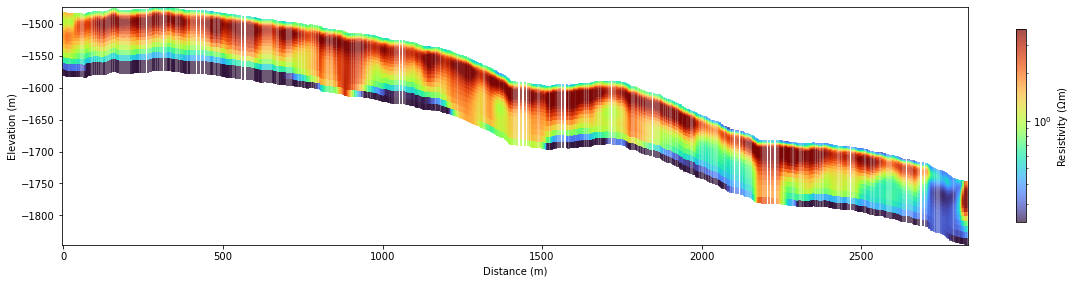

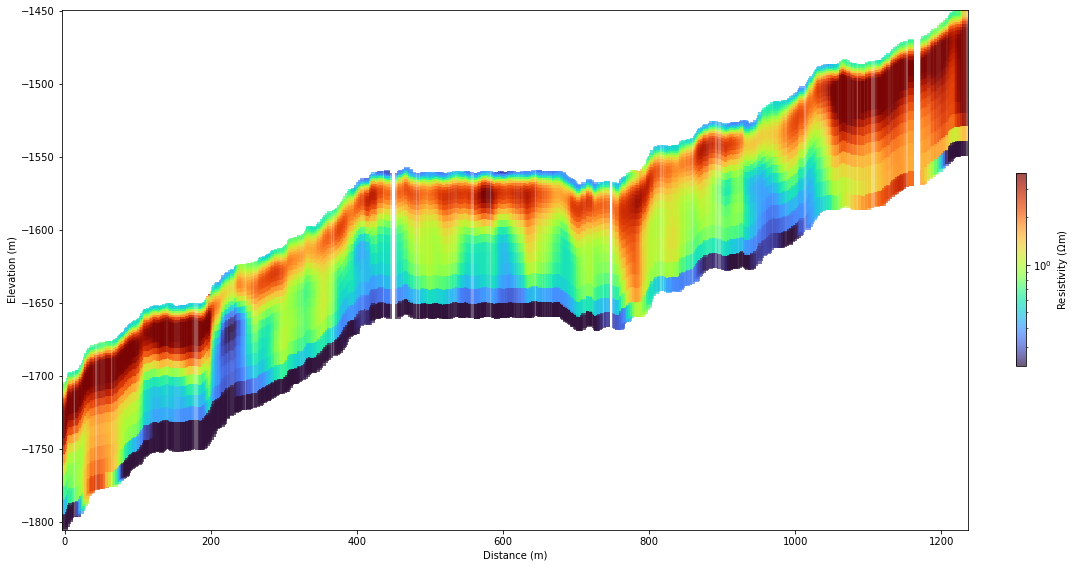

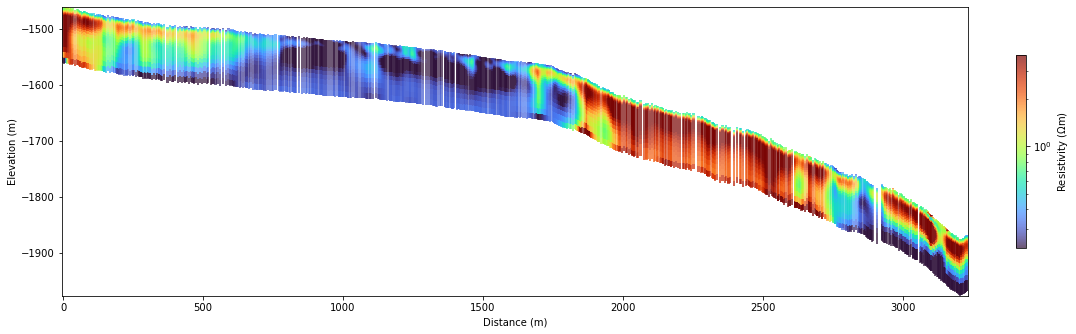

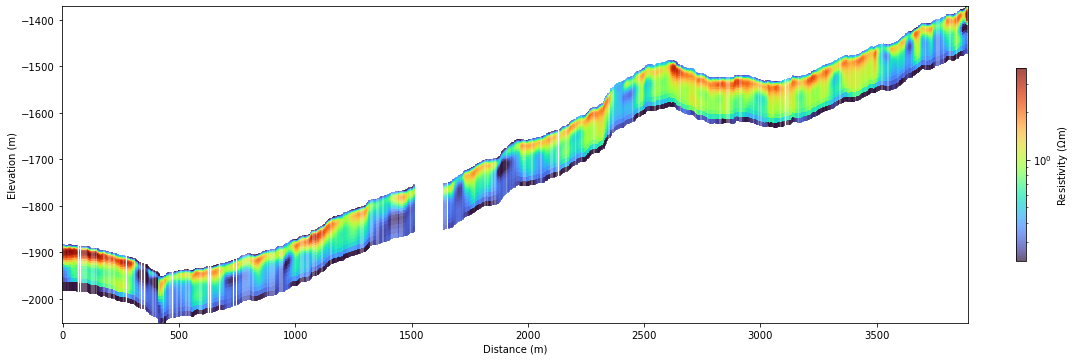

In [37]:
# Generate a Stitched1DModel object for plotting

model_plot = Stitched1DModel(
    hz=hz,
    line=line,
    topography=topography,
    #physical_property=1./np.exp(recovered_model),
    physical_property=1./np.exp(recovered_model),
)

for i_line in range(0,4):
    _, _, cb = model_plot.plot_section(i_line=i_line, aspect=2, x_axis='distance',dx=4, cmap='turbo')
    cb.set_label("Resistivity ($\Omega$m)")
            

In [173]:
np.min(np.exp(recovered_model))

5.1714389880740194e-05

D:\simpeg-em1d_updates\SimPEG\electromagnetics\utils\em1d_utils.py:536: UserWarning: code under construction - API might change in the future
  warnings.warn(
C:\Users\dell\anaconda3\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TensorMesh.vectorNx has been deprecated, please use TensorMesh.nodes_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


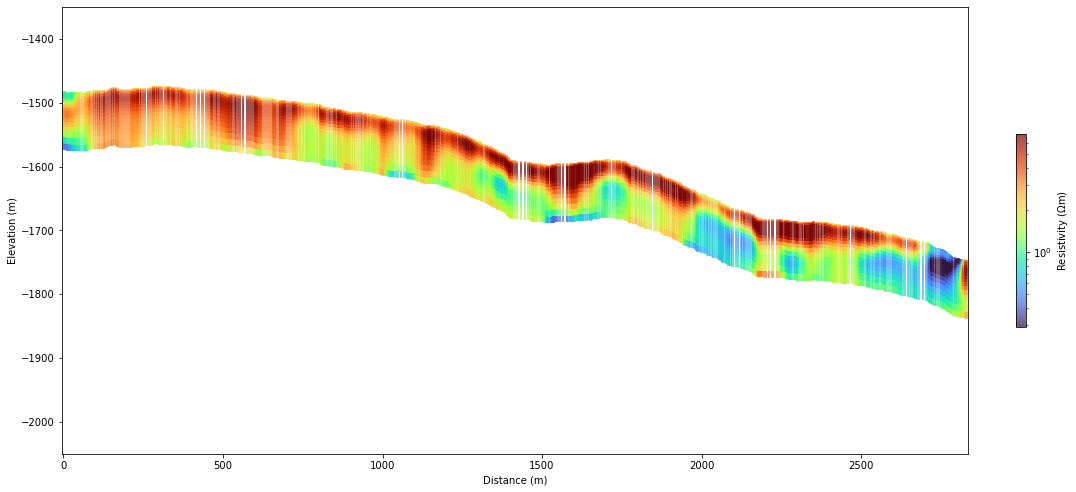

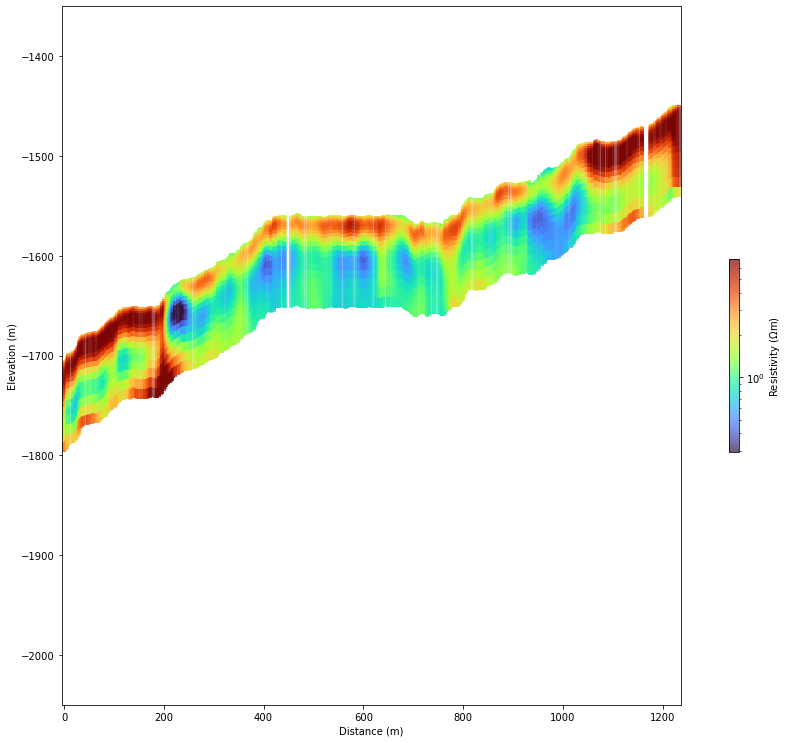

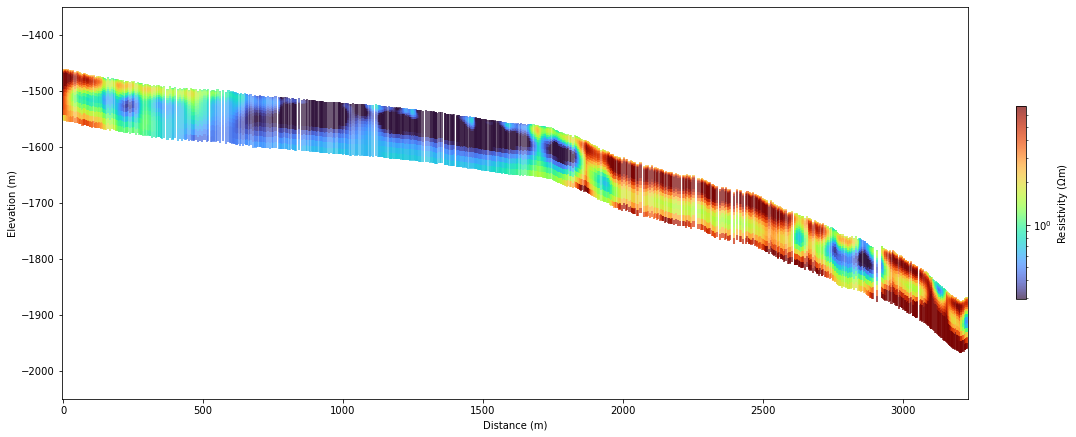

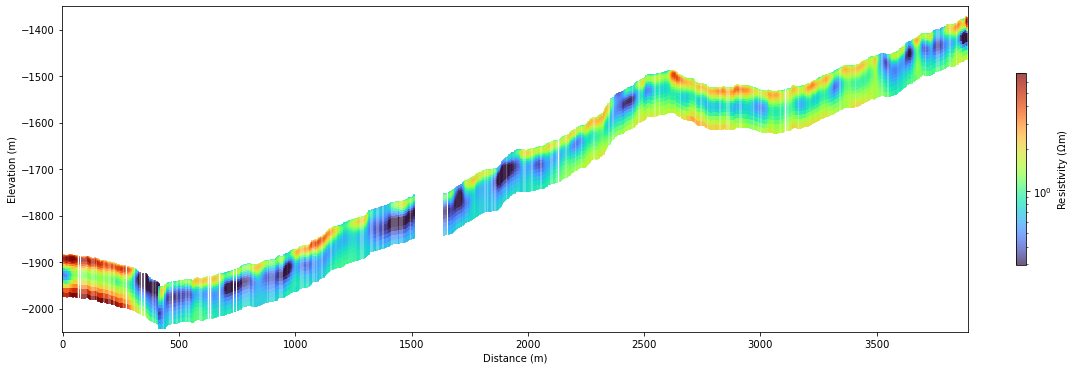

In [196]:
subset1 = xya[0:700]
subset1.shape
n_layers = 25
n_layers_p = 5
n_locations = len(recovered_model) // n_layers  # = 50

# reshape 
recovered_model_2d = recovered_model.reshape((n_locations, n_layers))

# Remove the bottom layers
resistivity_model = 1. / np.exp(recovered_model_2d[:, n_layers_p:])

# 
resistivity_model_flat = resistivity_model.flatten()

hz_plot = hz[n_layers_p:]

cut_model_plot = Stitched1DModel(
    hz=hz_plot,
    line=line,               
    topography=topography,   
    physical_property=resistivity_model_flat
)

for i_line in range(0,4):
    _, ax, cb = cut_model_plot.plot_section(i_line=i_line, aspect=2, x_axis='distance',dx=4, cmap='turbo')
    cb.set_label("Resistivity ($\Omega$m)")
    ax.set_ylim(-2050, -1350)


(<matplotlib.collections.QuadMesh object at 0x000001C34F943A90>, <AxesSubplot:xlabel='Distance (m)', ylabel='Elevation (m)'>, <matplotlib.colorbar.Colorbar object at 0x000001C34F943FD0>)


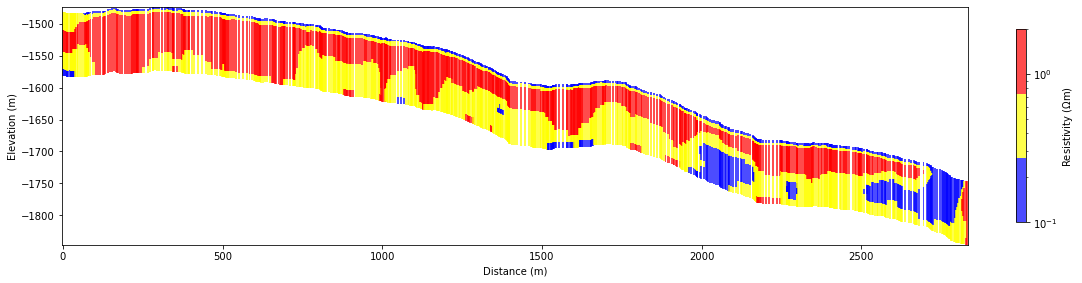

(<matplotlib.collections.QuadMesh object at 0x000001C350541460>, <AxesSubplot:xlabel='Distance (m)', ylabel='Elevation (m)'>, <matplotlib.colorbar.Colorbar object at 0x000001C35055C670>)


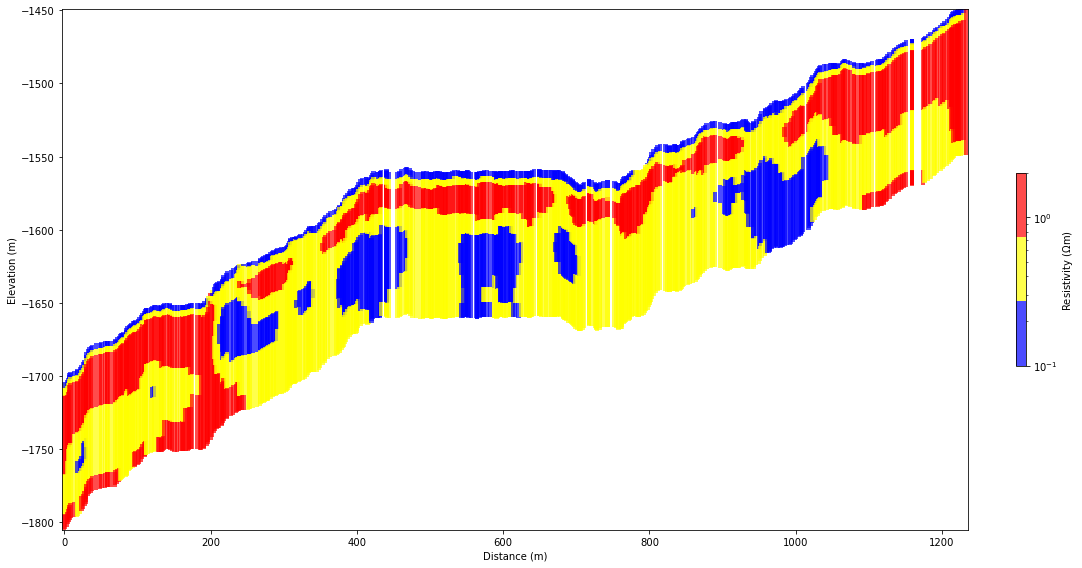

(<matplotlib.collections.QuadMesh object at 0x000001C351333460>, <AxesSubplot:xlabel='Distance (m)', ylabel='Elevation (m)'>, <matplotlib.colorbar.Colorbar object at 0x000001C35135F250>)


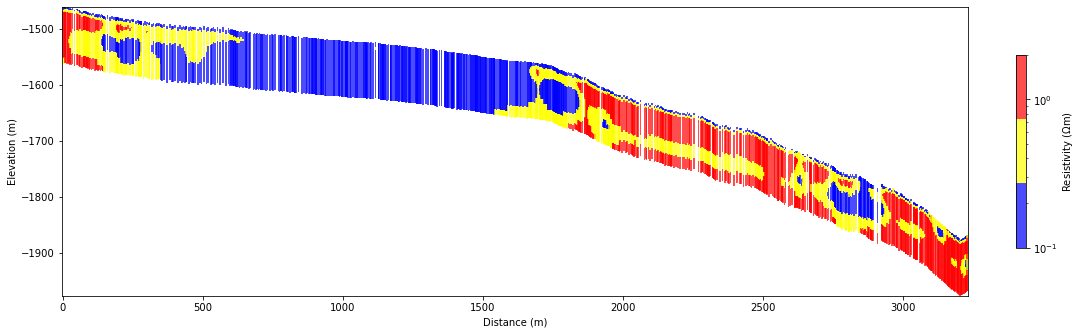

(<matplotlib.collections.QuadMesh object at 0x000001C35365C880>, <AxesSubplot:xlabel='Distance (m)', ylabel='Elevation (m)'>, <matplotlib.colorbar.Colorbar object at 0x000001C35368C430>)


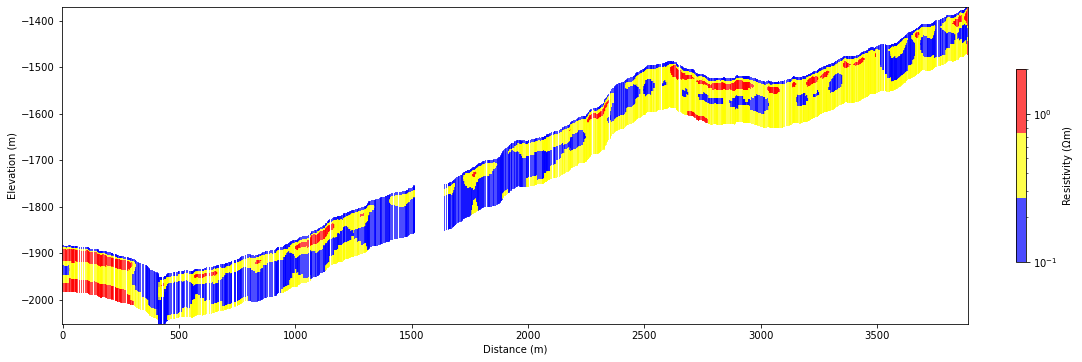

In [69]:
# Generate a Stitched1DModel object for plotting
cmap = mcolors.ListedColormap(['blue', 'yellow', 'red'])  # 自定义颜色
boundaries = [0.2, 0.8, 1.2, 2.2]  # 自定义边界
model_plot = Stitched1DModel(
    hz=hz,
    line=line,
    topography=topography,
    #physical_property=1./np.exp(recovered_model),
    physical_property=1./np.exp(recovered_model),
)

for i_line in range(0,4):
    result =_, _, cb = model_plot.plot_section(i_line=i_line, aspect=2, x_axis='distance',dx=3, cmap=cmap)
    cb.set_label("Resistivity ($\Omega$m)")
    
# Check what `result` contains
    print(result)  # This will help you understand the structure of the returned tuple
# Assuming the first element is the image object (ScalarMappable)
    im = result[0]  # Get the image object, not the axes object
    im.norm=norm  # Set the desired color range (e.g., 0.1 to 50)
    # Customize the colorbar (optional)
    cb = result[2]  # The third element should be the colorbar
    cb = plt.colorbar(im, ax=ax, boundaries=boundaries)
    cb.set_label("Resistivity ($\Omega$m)")  # Set colorbar label

# Display the plot
    plt.show()

In [37]:
len(times)

27

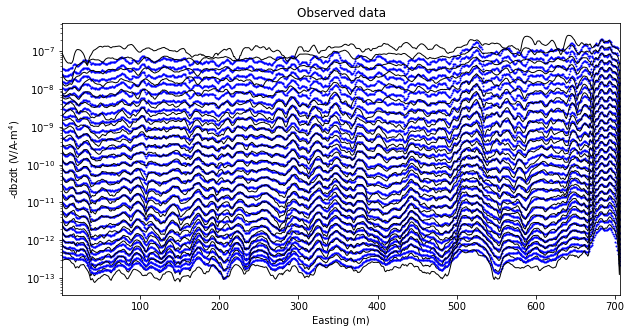

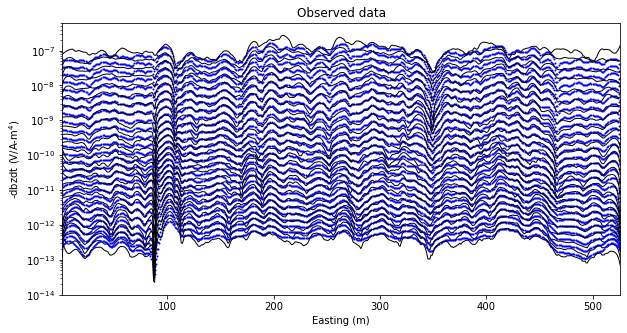

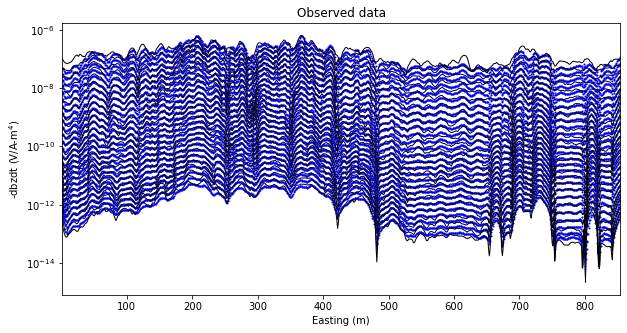

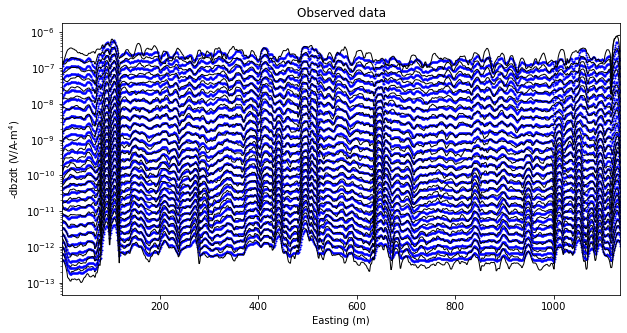

In [38]:

for i_lineno in range(0,4):
    x = group_line.get_group(uniq_line[i_lineno])['STATION'].values
    fig, ax = plt.subplots(1,1, figsize=(10, 5))
#     _, _, cb = model_plot.plot_section(i_line=i_lineno, aspect=2, dx=4, cmap='turbo', x_axis='distance',ax=ax[1])
#     cb.set_label("Resistivity ($\Omega$m)")


    ind_line = line == i_lineno+1
    for ii in range(0,len(times)):
        #ax[0].semilogy(receiver_locations[ind_line, 0], d_pred_field[ind_line, ii], 'k-', lw=1)
        ax.semilogy(x, -d_pred_field[ind_line, ii], 'b.',markersize=2, lw=0.5)
        ax.semilogy(x, -dobs_norm[ind_line, ii],'k-', lw=1 )


    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("-dbzdt (V/A-m$^4$)")
    ax.set_title("Observed data")
    ax.set_xlim([np.min(x),np.max(x)])

In [161]:
RMS = np.sqrt(5.18e+05 / len(dpred))
RMS

2.440170821705224

In [163]:
len(dpred)

86994

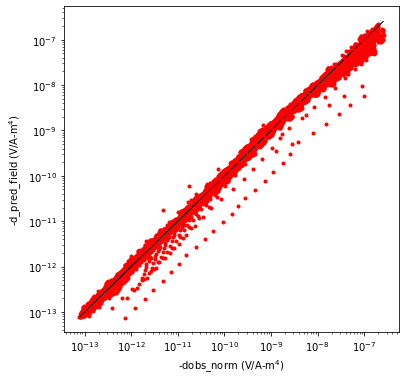

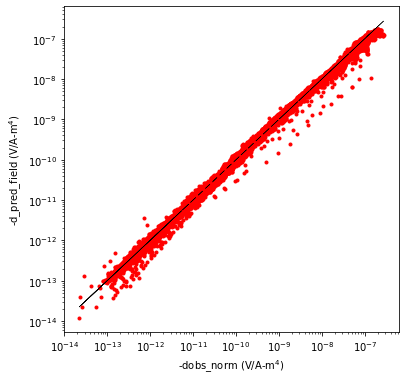

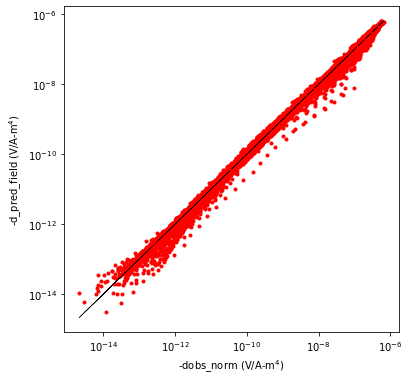

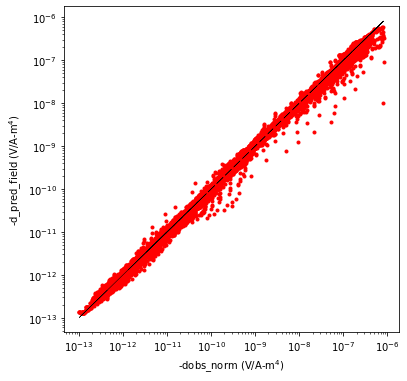

In [115]:
for i_lineno in range(0,4):
    fig, ax = plt.subplots(1,1,figsize=(6, 6))
    ind_line = line == i_lineno+1
    
    for ii in range(0,len(times)):
        #ax[0].semilogy(receiver_locations[ind_line, 0], d_pred_field[ind_line, ii], 'k-', lw=1)
        ax.loglog(-dobs_norm[ind_line, ii], -d_pred_field[ind_line, ii], 'r.', lw=1)
        ax.loglog(-dobs_norm[ind_line, ii], -dobs_norm[ind_line, ii], 'k', lw=0.5)


    ax.set_xlabel("-dobs_norm (V/A-m$^4$)")
    ax.set_ylabel("-d_pred_field (V/A-m$^4$)")

In [116]:
import csv
import pandas as pd
#writer=pd.ExcelWriter('test4.xlsx')
list1=recovered_model

In [117]:
print(list1.shape)

(80550,)


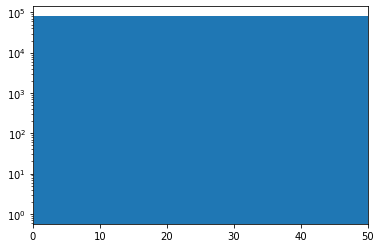

In [119]:
plt.hist(model_plot.physical_property,100);
plt.xlim(0, 50)
plt.yscale('log')

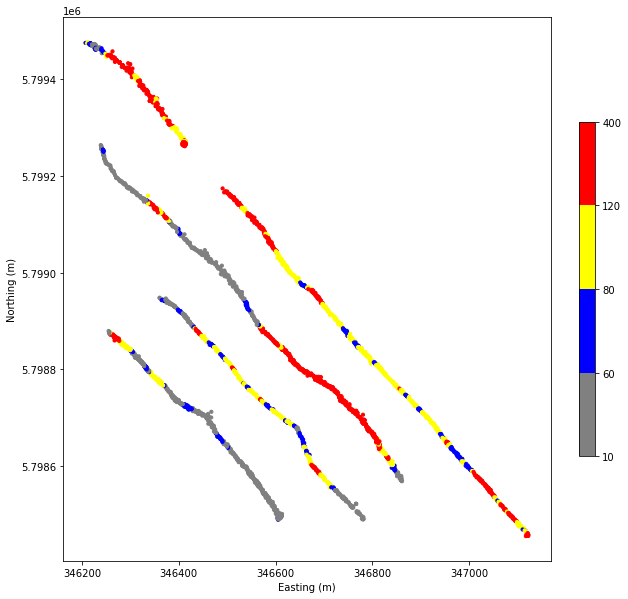

In [195]:
cmap = mcolors.ListedColormap(['gray','blue', 'yellow', 'red'])  # color
boundaries = [10, 60, 80,120,400]  # 
norm = mcolors.BoundaryNorm(boundaries, cmap.N) 

from matplotlib.colors import LogNorm
fig  = plt.figure(figsize=(10, 10))
i_layer = 4
out = plt.scatter(
    topography[:,0], topography[:,1], c=RES[:,1], 
    s=10, 
    norm=norm, #
    cmap=cmap
)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(out, fraction=0.03)
plt.gca().set_aspect(1)
plt.savefig('平面电导.eps', format='eps', dpi=300)

In [176]:
data_filename = dir_path + "ConductanceDeepRef.txt"
Conductance = np.loadtxt(data_filename)
Conductance.shape
RES=resistivity
RES[:,1]=Conductance

In [168]:
np.savetxt('Resis.txt',np.exp(recovered_model.flatten()),)